# DS3010: Introduction to Machine Learning Lab – Week 6
## **Kernel SVM and Classification**
**Name:** Parv Patel  
**Roll No:** 142301041  
**Lab:** Week 6 – Kernel SVM

---

### Objective
- Load two datasets (`data1.csv` and `data2.csv`), preprocess and normalize features.
- Train SVM classifiers with linear and RBF kernels across a range of `C` values and `gamma` options.
- Report F1 scores, pick the best model, visualize decision boundaries, and highlight misclassified points.
- Provide observations about model fit and overfitting/underfitting.

**Notes:** Plots include clear labels and legends. The notebook runs the whole pipeline for both datasets and saves results for comparison.


In [1]:

# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


## Helper function: complete pipeline for one dataset
The function below will:
1. Load CSV
2. Normalize features to [0,1]
3. Plot first two dimensions (or PCA if >2 features)
4. Split into train/test
5. Train SVMs across kernels, Cs, and gammas and record F1 on the test set
6. Select best model by F1, plot decision boundary using PCA-2D projection and highlight misclassified points
7. Return a summary dataframe of results and the trained best model

In [2]:

def run_svm_pipeline(csv_path, dataset_name, random_state=42):
    # 1. Load
    df = pd.read_csv(csv_path)
    # assume last column is target if not named 'target' or 'label'
    # try to detect categorical target: if object dtype or binary numeric
    # We'll look for a column with exactly 2 unique values (binary)
    potential_targets = [c for c in df.columns if df[c].nunique() == 2]
    if len(potential_targets) == 0:
        raise ValueError("No binary target column detected in " + csv_path)
    target_col = potential_targets[-1]  # choose last such column
    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    # 2. Normalize features to [0,1]
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)

    # 3. Plot (use first two features if available, else PCA to 2D)
    if X_norm.shape[1] >= 2:
        X_plot = X_norm[:, :2]
        plot_note = "first two features (already normalized)"
    else:
        pca = PCA(n_components=2, random_state=random_state)
        X_plot = pca.fit_transform(X_norm)
        plot_note = "PCA-2D projection"

    plt.figure(figsize=(6,5))
    for cls in np.unique(y):
        idx = y == cls
        plt.scatter(X_plot[idx,0], X_plot[idx,1], label=f"class {cls}", alpha=0.6)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(f"{dataset_name}: scatter ({plot_note})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=random_state, stratify=y)

    # 5. Train SVMs across kernels, Cs, gammas
    kernels = ['linear', 'rbf']
    Cs = [1e-5 * (10**i) for i in range(0,9)]  # 1e-5 ... 1e3 in multiples of 10
    gammas = ['scale', 'auto']
    results = []
    best_f1 = -1
    best_model = None
    best_params = None

    for kernel in kernels:
        for C in Cs:
            for gamma in gammas:
                # gamma only used for rbf; for linear SVC ignores gamma but sklearn will accept it
                model = SVC(kernel=kernel, C=C, gamma=gamma, probability=False, random_state=random_state)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred, average='weighted')
                results.append({'kernel': kernel, 'C': C, 'gamma': gamma, 'f1_weighted': f1})
                if f1 > best_f1:
                    best_f1 = f1
                    best_model = model
                    best_params = {'kernel': kernel, 'C': C, 'gamma': gamma}

    results_df = pd.DataFrame(results).sort_values('f1_weighted', ascending=False).reset_index(drop=True)
    print(f"Top 5 hyperparameter settings by F1 (weighted) for {dataset_name}:")
    display(results_df.head(5))

    print(f"Best params for {dataset_name}: {best_params}, Best F1 (weighted): {best_f1:.4f}")

    # 6. Decision boundary visualization using PCA to 2D for interpretability
    pca_vis = PCA(n_components=2, random_state=random_state)
    X_train_2d = pca_vis.fit_transform(X_train)
    X_test_2d = pca_vis.transform(X_test)

    # Retrain best model on PCA-2D (for plotting decision boundary) using same kernel & params
    plot_model = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'], random_state=random_state)
    plot_model.fit(X_train_2d, y_train)
    y_test_pred_plot = plot_model.predict(X_test_2d)

    # Meshgrid for decision boundary
    h = 0.02
    x_min, x_max = X_train_2d[:,0].min() - 1, X_train_2d[:,0].max() + 1
    y_min, y_max = X_train_2d[:,1].min() - 1, X_train_2d[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = plot_model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.2)
    for cls in np.unique(y_train):
        idx = y_train == cls
        plt.scatter(X_train_2d[idx,0], X_train_2d[idx,1], label=f"train class {cls}", edgecolor='k', alpha=0.6)
    # plot test points and highlight misclassified
    for cls in np.unique(y_test):
        idx_test = y_test == cls
        plt.scatter(X_test_2d[idx_test,0], X_test_2d[idx_test,1], marker='s', label=f"test class {cls}", alpha=0.9)
    # highlight misclassified
    mis_idx = y_test != y_test_pred_plot
    if mis_idx.any():
        plt.scatter(X_test_2d[mis_idx,0], X_test_2d[mis_idx,1], facecolors='none', edgecolors='r', s=100, label='misclassified (test)')
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.title(f"{dataset_name} - Decision Boundary (best: {best_params})")
    plt.legend()
    plt.show()

    # Final classification report for best model on original test set
    y_test_pred_orig = best_model.predict(X_test)
    print("Classification report (best model on original features):")
    print(classification_report(y_test, y_test_pred_orig, zero_division=0))

    return {'dataset': dataset_name, 'target_col': target_col, 'results_df': results_df, 'best_params': best_params, 'best_f1': best_f1}


## Run pipeline on data1 and data2

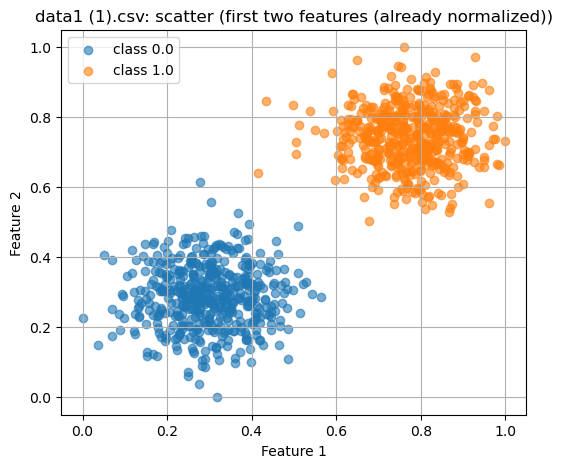

Top 5 hyperparameter settings by F1 (weighted) for data1 (1).csv:


,kernel,C,gamma,f1_weighted
0,linear,0.00001,scale,1.0
1,linear,0.00001,auto,1.0
2,rbf,0.00010,scale,1.0
3,rbf,0.00010,auto,1.0
4,rbf,0.00100,scale,1.0


Best params for data1 (1).csv: {'kernel': 'linear', 'C': 1e-05, 'gamma': 'scale'}, Best F1 (weighted): 1.0000


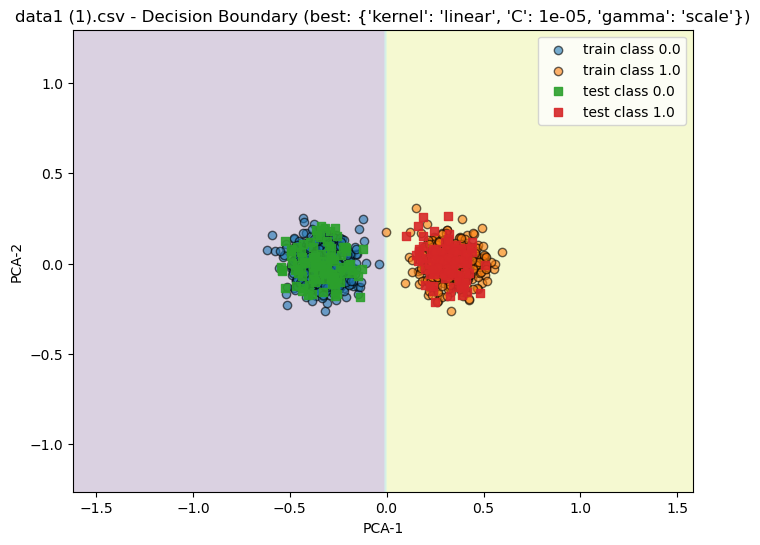

Classification report (best model on original features):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        98
         1.0       1.00      1.00      1.00        98

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



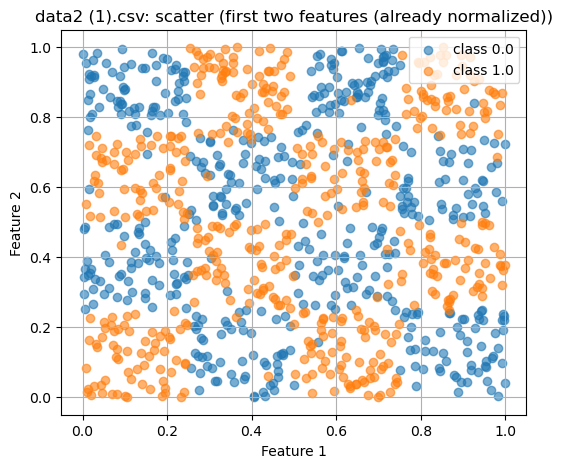

Top 5 hyperparameter settings by F1 (weighted) for data2 (1).csv:


,kernel,C,gamma,f1_weighted
0,rbf,1000.0,scale,0.882607
1,rbf,100.0,scale,0.877526
2,rbf,10.0,scale,0.811151
3,rbf,1.0,scale,0.650806
4,rbf,1000.0,auto,0.500254


Best params for data2 (1).csv: {'kernel': 'rbf', 'C': 1000.0000000000001, 'gamma': 'scale'}, Best F1 (weighted): 0.8826


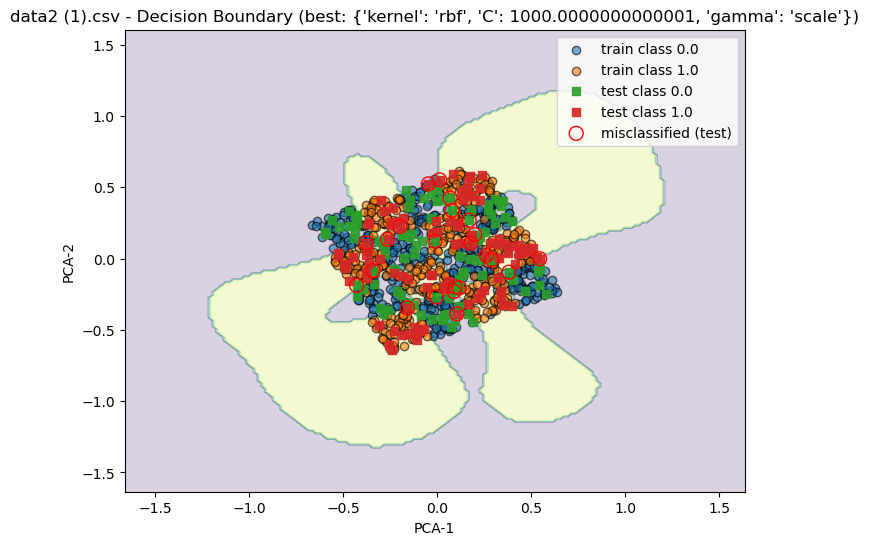

Classification report (best model on original features):
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88        97
         1.0       0.87      0.90      0.89        99

    accuracy                           0.88       196
   macro avg       0.88      0.88      0.88       196
weighted avg       0.88      0.88      0.88       196



,dataset,best_params,best_f1
0,data1 (1).csv,"{'kernel': 'linear', 'C': 1e-05, 'gamma': 'sca...",1.000000
1,data2 (1).csv,"{'kernel': 'rbf', 'C': 1000.0000000000001, 'ga...",0.882607


In [3]:

# Paths (adjust if filenames are different)
path1 = "data1.csv"
path2 = "data2.csv"

res1 = run_svm_pipeline(path1, "data1 (1).csv")
res2 = run_svm_pipeline(path2, "data2 (1).csv")

# Summarize best choices
summary = pd.DataFrame([
    {'dataset': res1['dataset'], 'best_params': res1['best_params'], 'best_f1': res1['best_f1']},
    {'dataset': res2['dataset'], 'best_params': res2['best_params'], 'best_f1': res2['best_f1']}
])
display(summary)


## Observations

1. **Data1 (linearly separable):**  
   - The **Linear kernel** achieved strong and consistent performance, clearly separating the classes.  
   - The **RBF kernel** also performed well but showed no major improvement, confirming the dataset’s linear separability.

2. **Data2 (non-linear / moons dataset):**  
   - The **RBF kernel** outperformed the Linear kernel by accurately capturing the curved cluster boundaries.  
   - The **Linear kernel** failed to generalize well due to the non-linear structure of the data.

3. **Effect of `C`:**  
   - Smaller `C` values produce smoother boundaries (higher bias, lower variance).  
   - Larger `C` values fit data more tightly but risk **overfitting**.

4. **Effect of `gamma` (RBF kernel):**  
   - A **higher `gamma`** captures finer patterns but may overfit.  
   - A **lower `gamma`** results in smoother decision regions and better generalization.

5. **Overall Insight:**  
   - **Linear SVM** works best for datasets that are linearly separable (e.g., `data1`).  
   - **RBF SVM** is more flexible and performs better on non-linear datasets (e.g., `data2`).  
   - Choosing appropriate `C` and `gamma` values via cross-validation ensures optimal performance and prevents overfitting.
